# Aula 3 - validação cruzada

Na aula de hoje, vamos explorar os seguintes tópicos em Python:

- 1) Validação cruzada (cross validation)
- 2) Ajuste de hiperparâmetros

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

____
____
____

## 1) Validação cruzada (cross validation)

O cross validation (CV) é uma das técnicas mais importantes no ferramental de um cientista de dados.

Operacionalmente, o CV implementa diferentes conjuntos de treino e teste (aqui chamados de **validação**), criando efetivamente diferentes modelos treinados e avaliados em diferentes suconjuntos aleatórios (os chamados **folds**) da base de dados original. 

No fim, é possível inspecionar as métricas de interesse em cada fold, bem como ter uma ideia da performance média do modelo, olhando para **a distribuição das métricas de avaliação**.

Note que este procedimento está intimamente relacionado com a avaliação da desejável habilidade de **generalização do modelo**!

A forma mais comum de fazermos CV é através da técnica **k-fold**:

<img src=https://scikit-learn.org/stable/_images/grid_search_cross_validation.png width=500>

No extremo desta abordagem, podemos tomar o número $k$ de folds igual ao número de observações na base ($n$). Neste caso, utiliza-se **uma única** observação para teste, enquanto o resto do dataset é utilizado para treino. Essa abordagem é conhecida como **leave one out (LOO)**:

<img src=https://assets.datacamp.com/production/repositories/3981/datasets/8a6236f142b1ee2e4a70aae2af9507c7c580f302/Screen%20Shot%202019-01-27%20at%209.25.41%20AM.png width=500>

Note que o esforço computacional aumenta conforme $k$ aumenta, sendo máximo quando $k=n$. Por esse motivo, recomenda-se usar o LOO apenas nos casos em que o número de observções na base original é bem pequeno ($\sim 10^2$).

Vamos implementar o procedimento de CV utilizando o sklearn!

No [submódulo model_selection](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection), temos duas ferramentas muito importantes para o processo de CV:

- [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold): classe que cria os folds. Obs.: para fazer o LOO, basta colocar $k=n$ folds, ou então usar diretamente a classe que implementa o [LOO](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html#sklearn.model_selection.LeaveOneOut);

- [cross_validate](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate): função que recebe os folds e os utiliza para o treinamento e avaliação cruzada de modelos, segundo a métrica definida.

Para ilustrar o CV,  vamos utilizar os datasets artificiais que o sklearn proporciona:

_______

Vamos começar com um exemplo de **regressão**

In [2]:
from sklearn.datasets import make_regression

# Usando um dataset de dentro do sklearn para criar dados
X, y = make_regression(n_samples=500,
                       n_features=5,
                       n_informative=3,
                       noise=25,
                       tail_strength=10,
                       random_state=42)

In [10]:
# Criando o dataframe com os dados gerados 
X_df = pd.DataFrame(X, columns=[f'X{i+1}' for i in range (X.shape[1])])

y_df = pd.Series(y, name='y')

df = pd.concat([X_df, y_df], axis=1)

df

,X1,X2,X3,X4,X5,y
0,-0.109610,0.546284,-0.088363,0.006422,-0.436386,79.870807
1,-1.024388,-0.926930,-0.252568,-0.059525,-3.241267,-115.324859
2,-2.650970,0.106430,1.091507,-0.254977,1.503993,35.552509
3,-0.850520,-0.138456,-0.580523,-1.224298,-0.209023,-145.413703
4,-0.322680,-0.756795,-0.250833,-1.421811,1.501334,-116.148875
...,...,...,...,...,...,...
495,-1.363174,-1.598124,0.189706,0.462173,2.024310,-87.798391
496,0.239247,-1.979300,2.074083,0.747910,-1.072743,-92.452927
497,2.189803,-0.767348,-0.808298,0.872321,0.183342,20.274546
498,0.615367,0.513106,-0.935439,-0.259547,0.738810,43.199300


In [11]:
df.corr()

,X1,X2,X3,X4,X5,y
X1,1.000000,0.022302,-0.038972,-0.057761,-0.004161,-0.022682
X2,0.022302,1.000000,-0.027835,0.003858,0.060716,0.730179
X3,-0.038972,-0.027835,1.000000,0.039600,0.020429,0.007996
X4,-0.057761,0.003858,0.039600,1.000000,0.008688,0.641558
X5,-0.004161,0.060716,0.020429,0.008688,1.000000,0.155999
y,-0.022682,0.730179,0.007996,0.641558,0.155999,1.000000


<AxesSubplot:>

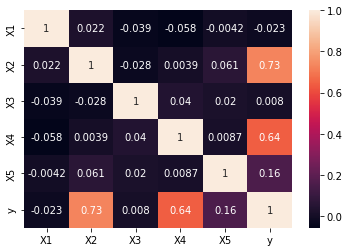

In [13]:
sns.heatmap(df.corr(), annot=True)

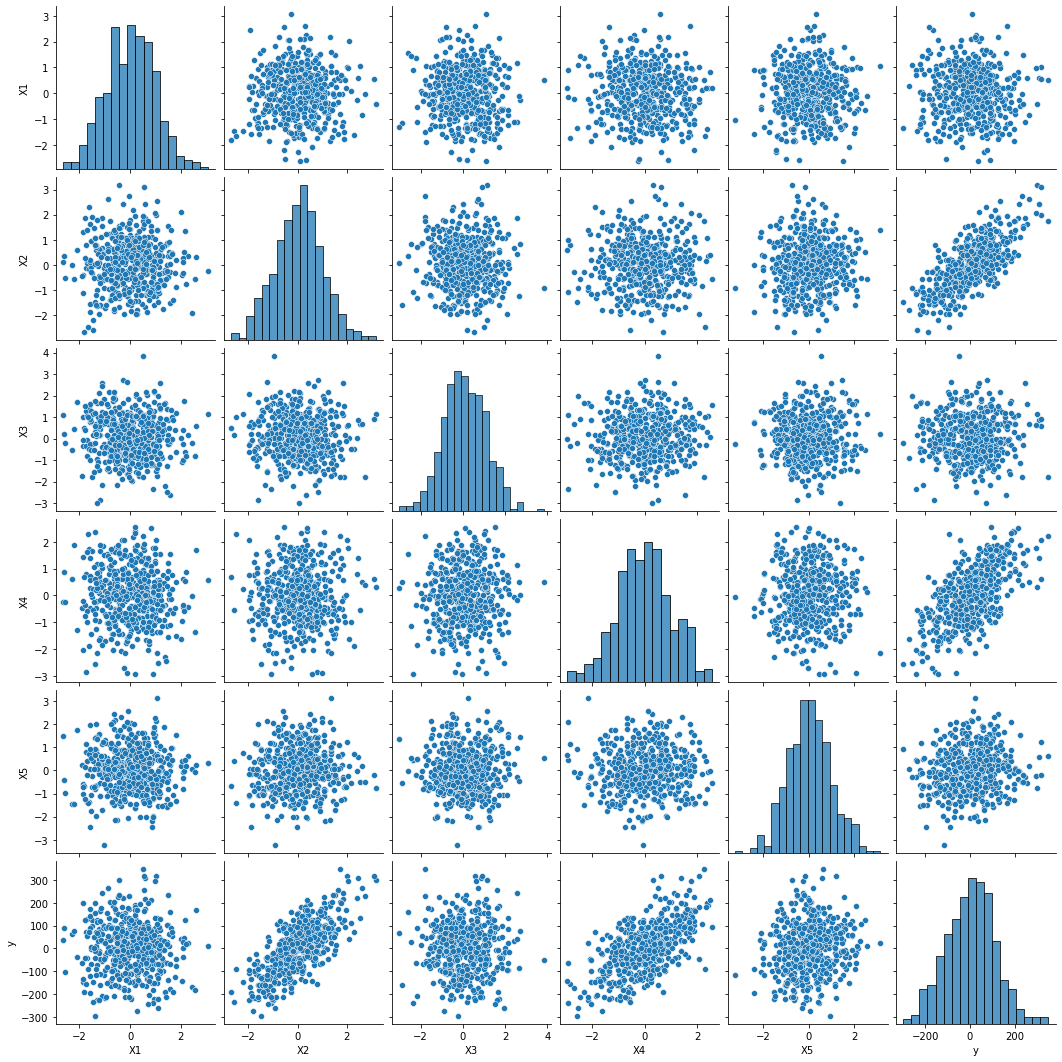

In [14]:
sns.pairplot(df)

In [15]:
df.describe()

,X1,X2,X3,X4,X5,y
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.012412,0.047211,0.089335,-0.004983,0.024845,3.420332
std,0.955087,0.969309,0.999397,1.038814,0.949985,110.693405
min,-2.650970,-2.703232,-3.019512,-2.940389,-3.241267,-297.665107
25%,-0.642849,-0.577418,-0.576895,-0.682826,-0.644153,-68.294863
50%,0.033078,0.081273,0.040829,-0.024875,0.008918,4.208483
75%,0.658720,0.668974,0.751524,0.671004,0.635892,76.120529
max,3.078881,3.193108,3.852731,2.558199,3.137749,349.448456


Os dados não têm variação de escala tão grande, então não nos preocuparemos em normalizá-los, caso queiramos utilizar regularização!

**Mas nunca se esqueça que isso é bastante importante quando há grandes diferenças de escala!!**


Agora, implementamos o CV:

In [16]:
from sklearn.model_selection import KFold

In [35]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [36]:
vars(kf)

{'n_splits': 5, 'shuffle': True, 'random_state': 42}

In [37]:
# verificando quantos splits (divisões) vão ter

len(list(kf.split(X)))

5

In [38]:
# em cada split, temos uma tupla ([indices de treino], [indice de validação])
# como visto, isso é feito em cada split
# o que temos abixo é apenas o primeiro split (indice 0)

list(kf.split(X))[0]

(array([  1,   3,   4,   5,   6,   7,   8,  10,  12,  13,  14,  16,  17,
         19,  20,  21,  23,  24,  25,  26,  27,  28,  29,  31,  32,  34,
         35,  36,  37,  38,  40,  41,  42,  43,  44,  45,  47,  48,  49,
         50,  51,  52,  53,  54,  56,  57,  58,  59,  60,  61,  62,  64,
         65,  66,  67,  71,  74,  80,  81,  83,  85,  87,  88,  89,  91,
         92,  94,  95,  96,  97,  98,  99, 100, 102, 103, 105, 106, 107,
        108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
        121, 122, 123, 125, 126, 127, 128, 129, 130, 132, 133, 134, 135,
        136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 149,
        150, 151, 152, 153, 156, 157, 158, 159, 160, 161, 162, 163, 164,
        165, 166, 167, 168, 169, 170, 171, 174, 175, 176, 177, 178, 179,
        181, 183, 184, 186, 187, 188, 189, 190, 191, 192, 195, 196, 197,
        198, 199, 200, 201, 202, 203, 205, 206, 207, 208, 210, 212, 213,
        214, 215, 216, 217, 218, 219, 220, 221, 222

In [39]:
idcs_treino, idcs_val = list(kf.split(X))[0]

In [40]:
idcs_val

array([  0,   2,   9,  11,  15,  18,  22,  30,  33,  39,  46,  55,  63,
        68,  69,  70,  72,  73,  75,  76,  77,  78,  79,  82,  84,  86,
        90,  93, 101, 104, 124, 131, 148, 154, 155, 172, 173, 180, 182,
       185, 193, 194, 204, 209, 211, 238, 262, 268, 277, 278, 280, 290,
       304, 312, 316, 317, 321, 323, 324, 333, 334, 336, 341, 347, 352,
       356, 361, 362, 371, 374, 377, 381, 384, 388, 391, 394, 406, 408,
       409, 410, 414, 415, 431, 438, 440, 450, 451, 455, 461, 465, 472,
       475, 477, 483, 485, 490, 491, 494, 495, 497])

In [41]:
idcs_treino

array([  1,   3,   4,   5,   6,   7,   8,  10,  12,  13,  14,  16,  17,
        19,  20,  21,  23,  24,  25,  26,  27,  28,  29,  31,  32,  34,
        35,  36,  37,  38,  40,  41,  42,  43,  44,  45,  47,  48,  49,
        50,  51,  52,  53,  54,  56,  57,  58,  59,  60,  61,  62,  64,
        65,  66,  67,  71,  74,  80,  81,  83,  85,  87,  88,  89,  91,
        92,  94,  95,  96,  97,  98,  99, 100, 102, 103, 105, 106, 107,
       108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
       121, 122, 123, 125, 126, 127, 128, 129, 130, 132, 133, 134, 135,
       136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 149,
       150, 151, 152, 153, 156, 157, 158, 159, 160, 161, 162, 163, 164,
       165, 166, 167, 168, 169, 170, 171, 174, 175, 176, 177, 178, 179,
       181, 183, 184, 186, 187, 188, 189, 190, 191, 192, 195, 196, 197,
       198, 199, 200, 201, 202, 203, 205, 206, 207, 208, 210, 212, 213,
       214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 22

Como vimos acima, a classe KFold só gera os splits.

Mas, na prática, vamos usar o `cross_validate()`, que tem o KFold como argumento!!!

In [42]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import ElasticNet

In [43]:
en = ElasticNet()
kf5 = KFold(n_splits=5, shuffle=True, random_state=42)

result_cv = cross_validate(
    estimator=en,
    X=X,
    y=y,
    cv=kf5,
    scoring='neg_mean_absolute_error',
    return_train_score=True
)  #https://scikit-learn.org/stable/modules/model_evaluation.html

In [44]:
result_cv

{'fit_time': array([0.0058496 , 0.00147915, 0.00049925, 0.        , 0.00099921]),
 'score_time': array([7.03334808e-05, 2.56776810e-04, 0.00000000e+00, 1.21355057e-03,
        0.00000000e+00]),
 'test_score': array([-37.24236843, -36.91545126, -33.87016282, -33.95473613,
        -33.5734684 ]),
 'train_score': array([-34.53892092, -34.92024842, -35.32918673, -35.49867268,
        -34.38269734])}

In [45]:
df_result_cv = pd.DataFrame(result_cv)

df_result_cv = df_result_cv.abs()

Vamos olhar pros resultados mais de perto...

In [46]:
df_result_cv

,fit_time,score_time,test_score,train_score
0,0.005850,0.000070,37.242368,34.538921
1,0.001479,0.000257,36.915451,34.920248
2,0.000499,0.000000,33.870163,35.329187
3,0.000000,0.001214,33.954736,35.498673
4,0.000999,0.000000,33.573468,34.382697


In [47]:
df_result_cv[['test_score','train_score']].describe()

,test_score,train_score
count,5.000000,5.000000
mean,35.111237,34.933945
std,1.805506,0.483539
min,33.573468,34.382697
25%,33.870163,34.538921
50%,33.954736,34.920248
75%,36.915451,35.329187
max,37.242368,35.498673


<AxesSubplot:xlabel='train_score', ylabel='Count'>

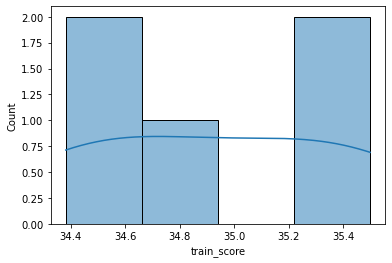

In [48]:
sns.histplot(data=df_result_cv, x='train_score', kde=True)

<AxesSubplot:xlabel='test_score', ylabel='Count'>

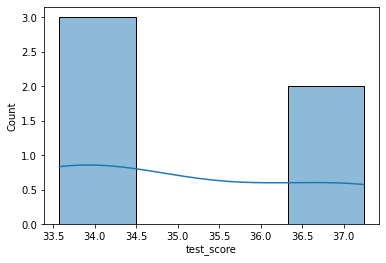

In [49]:
sns.histplot(data=df_result_cv, x='test_score', kde=True)

Numa unica celula:


In [50]:
#função
def plot_cv(estimator, X, y, n_splits, scoring):
    '''
    scoring: string relativa às métricas
    '''
    
    kf5 = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    result_cv = cross_validate(estimator=estimator, X=X, y=y, 
                               cv=kf5, scoring=scoring,
                               return_train_score=True)
    
    # ============================

    df_result_cv = pd.DataFrame(result_cv)
    df_result_cv = df_result_cv.abs()
    
    display(df_result_cv[["train_score", "test_score"]].describe())
    
    # ============================
    
    print("\nDistribuição de métricas de treino:")
    sns.histplot(data=df_result_cv, x="train_score", kde=True)
    plt.show()
    
    print("\nDistribuição de métricas de teste:")
    sns.histplot(data=df_result_cv, x="test_score", kde=True)
    plt.show()
    
    print("\nAs duas juntas (compare a variância!):")
    sns.histplot(data=df_result_cv, x="train_score", kde=True)
    sns.histplot(data=df_result_cv, x="test_score", color="orange", kde=True)
    plt.show()

,train_score,test_score
count,30.000000,30.000000
mean,34.913566,35.118937
std,0.144129,7.124084
min,34.683546,21.635696
25%,34.816336,30.535681
50%,34.885635,35.276464
75%,35.006462,39.876677
max,35.198265,47.729019



Distribuição de métricas de treino:


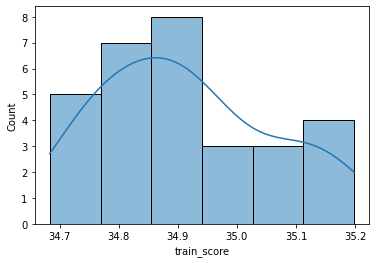


Distribuição de métricas de teste:


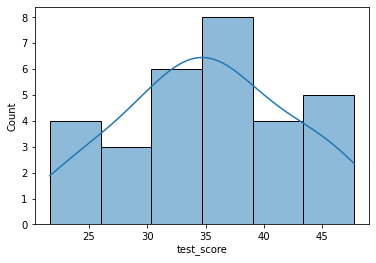


As duas juntas (compare a variância!):


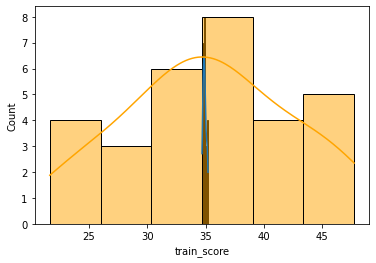

In [51]:
en = ElasticNet()

plot_cv(en, X, y, n_splits=30, scoring="neg_mean_absolute_error")

Comparando com o train-test split direto

In [52]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# ================================

en = ElasticNet().fit(X_train, y_train)

# ================================

from sklearn.metrics import mean_absolute_error

y_pred_train = en.predict(X_train)
print("\nMétrica de treino:")
print(mean_absolute_error(y_train, y_pred_train))

y_pred_test = en.predict(X_test)
print("\nMétrica de teste:")
print(mean_absolute_error(y_test, y_pred_test))


Métrica de treino:
34.52420837921775

Métrica de teste:
39.05591800744537


**Na prática, para bases maiores, nós fazemos realmente como está na figura lá em cima**

Isto é:

- primeiro fazemos o train-test split;
- aí, aplicamos CV na base de treino;
- depois testamos na base de teste

Isso é sobretudo importante no segundo "uso" do cv, que é otimização de hiperparametros

______
_____
____

Caso queira usar mais métricas de uma vez... SEM PROBLEMAS :)

In [54]:
n_splits = 5
estimator = ElasticNet()
scoring=("neg_mean_absolute_error", "neg_root_mean_squared_error", "r2")

kf5 = KFold(n_splits=n_splits, shuffle=True, random_state=42)

result_cv = cross_validate(estimator=estimator, X=X, y=y, 
                           cv=kf5, scoring=scoring,
                           return_train_score=True)

# ============================

df_result_cv = pd.DataFrame(result_cv)
df_result_cv = df_result_cv.abs()

df_result_cv

,fit_time,score_time,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error,test_r2,train_r2
0,0.001209,0.001005,37.242368,34.538921,45.674374,43.276767,0.829117,0.846058
1,0.000537,0.000000,36.915451,34.920248,46.934037,43.285737,0.830471,0.844345
2,0.000998,0.001037,33.870163,35.329187,42.583387,44.036324,0.858233,0.839472
3,0.001050,0.000000,33.954736,35.498673,43.581829,43.966468,0.845657,0.839496
4,0.000221,0.000515,33.573468,34.382697,40.419302,43.217668,0.837599,0.853698


,train_neg_mean_absolute_error,test_neg_mean_absolute_error
count,5.000000,5.000000
mean,34.933945,35.111237
std,0.483539,1.805506
min,34.382697,33.573468
25%,34.538921,33.870163
50%,34.920248,33.954736
75%,35.329187,36.915451
max,35.498673,37.242368



Distribuição da métrica neg_mean_absolute_error de treino:


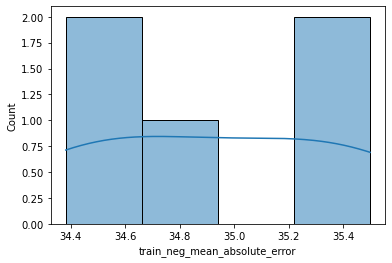


Distribuição da métrica neg_mean_absolute_error de teste:


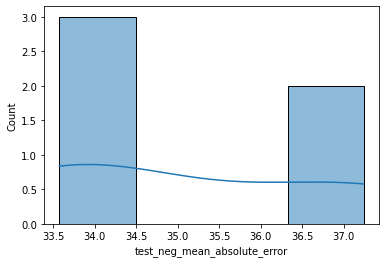

################################################################################


,train_neg_root_mean_squared_error,test_neg_root_mean_squared_error
count,5.000000,5.000000
mean,43.556593,43.838586
std,0.407638,2.563440
min,43.217668,40.419302
25%,43.276767,42.583387
50%,43.285737,43.581829
75%,43.966468,45.674374
max,44.036324,46.934037



Distribuição da métrica neg_root_mean_squared_error de treino:


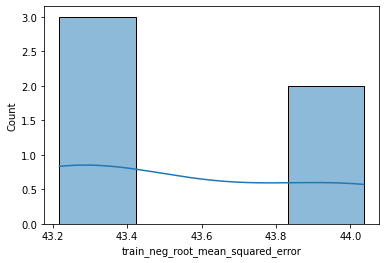


Distribuição da métrica neg_root_mean_squared_error de teste:


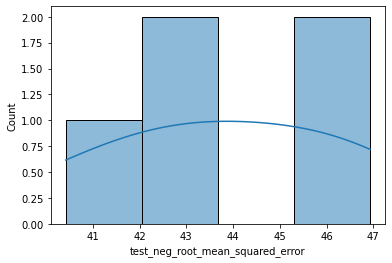

################################################################################


,train_r2,test_r2
count,5.000000,5.000000
mean,0.844614,0.840215
std,0.005859,0.012034
min,0.839472,0.829117
25%,0.839496,0.830471
50%,0.844345,0.837599
75%,0.846058,0.845657
max,0.853698,0.858233



Distribuição da métrica r2 de treino:


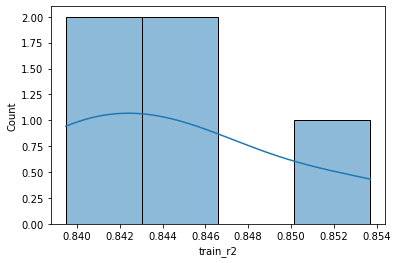


Distribuição da métrica r2 de teste:


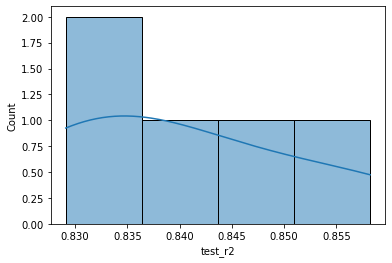

################################################################################


In [55]:
colunas_metricas = df_result_cv.columns.tolist()[2:]

for i in range(0, len(colunas_metricas), 2):
    
    display(df_result_cv[[colunas_metricas[i+1], colunas_metricas[i]]].describe())
    
    print(f'\nDistribuição da métrica {colunas_metricas[i+1].replace("train_", "")} de treino:')
    sns.histplot(data=df_result_cv, x=colunas_metricas[i+1], kde=True)
    plt.show()
    
    print(f'\nDistribuição da métrica {colunas_metricas[i].replace("test_", "")} de teste:')
    sns.histplot(data=df_result_cv, x=colunas_metricas[i], kde=True)
    plt.show()

    print("#"*80)

_______________

In [56]:
def plot_cv_varias_metricas(estimator, X, y, n_splits, scoring):
    '''
    scoring: tupla de strings relativas às métricas
    '''
    
    kf5 = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    result_cv = cross_validate(estimator=estimator, X=X, y=y, 
                               cv=kf5, scoring=scoring,
                               return_train_score=True)
    
    # ============================

    df_result_cv = pd.DataFrame(result_cv)
    df_result_cv = df_result_cv.abs()
    
    colunas_metricas = df_result_cv.columns.tolist()[2:]

    for i in range(0, len(colunas_metricas), 2):

        display(df_result_cv[[colunas_metricas[i+1], colunas_metricas[i]]].describe())

        print(f'\nDistribuição da métrica {colunas_metricas[i+1].replace("train_", "")} de treino:')
        sns.histplot(data=df_result_cv, x=colunas_metricas[i+1], kde=True)
        plt.show()

        print(f'\nDistribuição da métrica {colunas_metricas[i].replace("test_", "")} de teste:')
        sns.histplot(data=df_result_cv, x=colunas_metricas[i], kde=True)
        plt.show()

        print("\nAs duas juntas (compare a variância!):")
        sns.histplot(data=df_result_cv, x=colunas_metricas[i+1], label="treino", kde=True)
        sns.histplot(data=df_result_cv, x=colunas_metricas[i], color="orange", label="teste", kde=True)
        plt.legend()
        plt.show()
        
        print("#"*80)
    

,train_neg_mean_absolute_error,test_neg_mean_absolute_error
count,30.000000,30.000000
mean,34.913566,35.118937
std,0.144129,7.124084
min,34.683546,21.635696
25%,34.816336,30.535681
50%,34.885635,35.276464
75%,35.006462,39.876677
max,35.198265,47.729019



Distribuição da métrica neg_mean_absolute_error de treino:


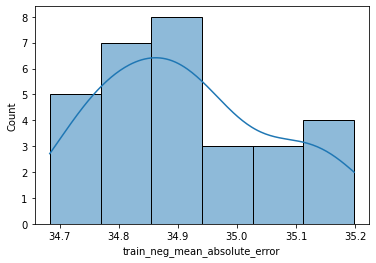


Distribuição da métrica neg_mean_absolute_error de teste:


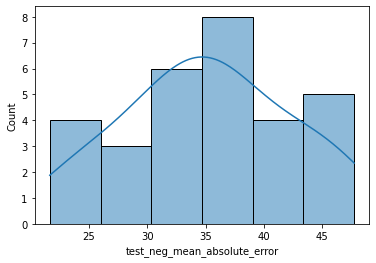


As duas juntas (compare a variância!):


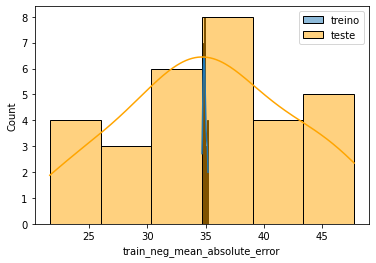

################################################################################


,train_neg_root_mean_squared_error,test_neg_root_mean_squared_error
count,30.000000,30.000000
mean,43.561148,43.161349
std,0.134884,7.876156
min,43.302666,27.779693
25%,43.473587,38.337612
50%,43.543192,42.605086
75%,43.634248,48.166132
max,43.839619,60.211813



Distribuição da métrica neg_root_mean_squared_error de treino:


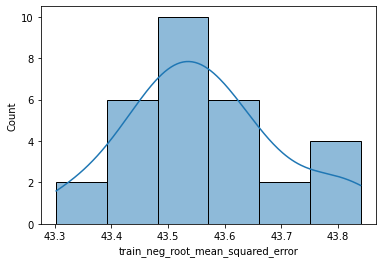


Distribuição da métrica neg_root_mean_squared_error de teste:


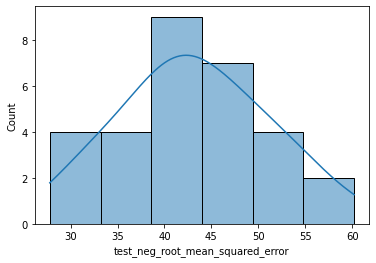


As duas juntas (compare a variância!):


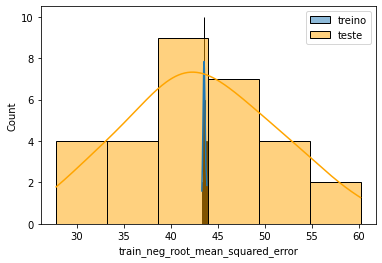

################################################################################


,train_r2,test_r2
count,30.000000,30.000000
mean,0.844783,0.828963
std,0.002616,0.036106
min,0.839848,0.749952
25%,0.842733,0.812329
50%,0.845213,0.826827
75%,0.846661,0.853945
max,0.849561,0.892042



Distribuição da métrica r2 de treino:


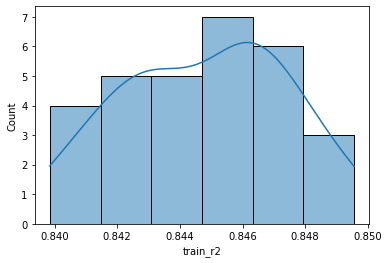


Distribuição da métrica r2 de teste:


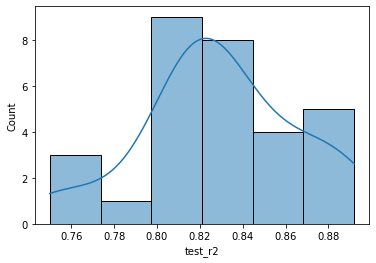


As duas juntas (compare a variância!):


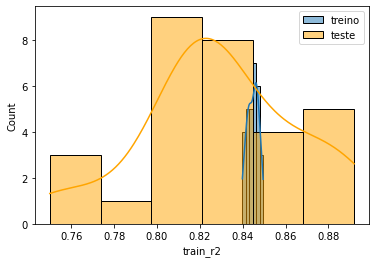

################################################################################


In [57]:
en = ElasticNet()
scoring=("neg_mean_absolute_error", "neg_root_mean_squared_error", "r2")

plot_cv_varias_metricas(en, X, y, n_splits=30, scoring=scoring)

_____

Vamos agora ver um caso de **classificação**:

In [58]:
from sklearn.datasets import make_classification

# gerando os dados
X_clf, y_clf = make_classification(n_samples=500,
                                 n_features=5, n_informative=3,
                                 n_classes=2,
                                 random_state=42)

X_clf_df = pd.DataFrame(X_clf, columns=[f'X{i+1}' for i in range(X_clf.shape[1])]) 
y_clf_df = pd.Series(y_clf, name="y")

#montando um dataframe
df_clf = pd.concat([X_clf_df, y_clf_df], axis=1)

df_clf

,X1,X2,X3,X4,X5,y
0,0.280056,-1.126421,-0.772964,2.060626,-2.357044,0
1,-0.326002,0.343967,1.535987,-1.794578,1.293605,1
2,-0.802972,-1.112616,-1.088524,0.668720,-1.183952,0
3,0.012285,-0.350602,-1.359103,1.234112,-0.909008,0
4,0.043145,-1.077267,-0.873334,1.727960,-2.031498,0
...,...,...,...,...,...,...
495,-0.487169,-0.351560,0.458356,-0.631618,0.076135,0
496,-0.114580,-1.433468,-0.513094,1.641968,-2.358049,0
497,-1.292011,-0.504030,0.758286,-1.832484,0.803280,1
498,0.287141,1.553864,0.125348,-1.272565,2.271871,1


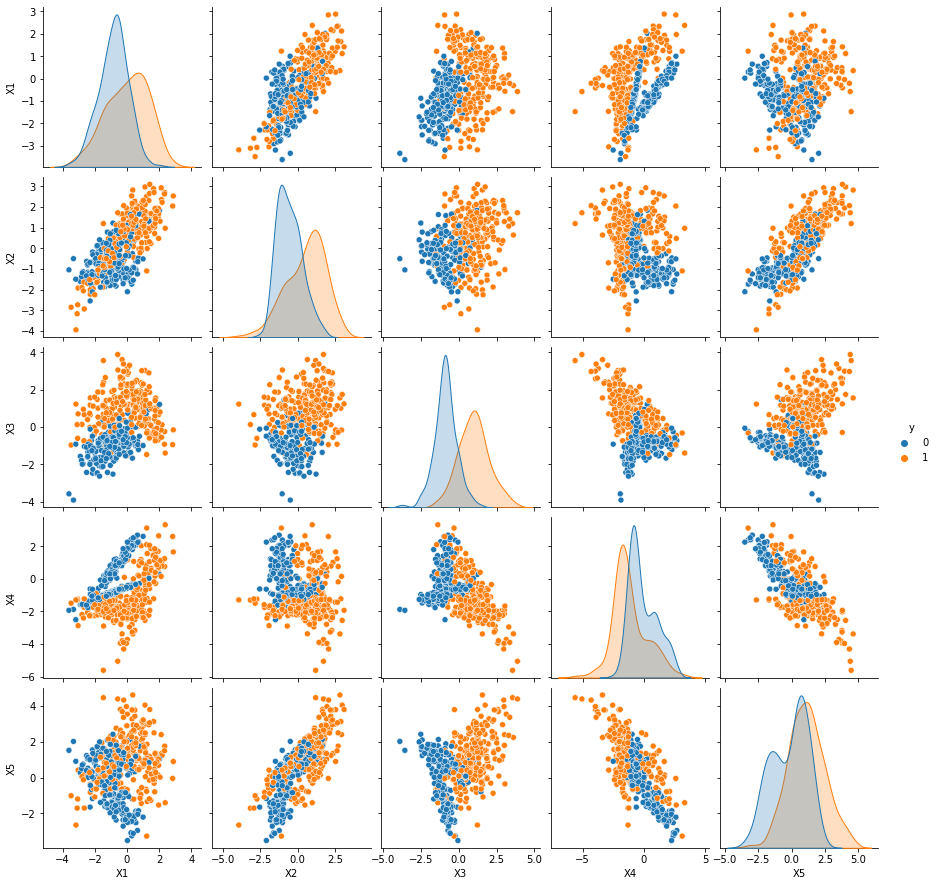

In [59]:
sns.pairplot(df_clf, hue="y")

Agora, o CV, bem parecido com o que fizemos acima:

- uma regressão logística com regularização l1 e fator de regularização (C) igual a 1.2;
- 10 folds;
- roc_auc como métrica de avaliação.

In [60]:
from sklearn.linear_model import LogisticRegression

,train_score,test_score
count,10.000000,10.000000
mean,0.942939,0.940544
std,0.002501,0.023745
min,0.940402,0.893268
25%,0.941518,0.935897
50%,0.941980,0.951190
75%,0.943034,0.953301
max,0.948221,0.967159



Distribuição de métricas de treino:


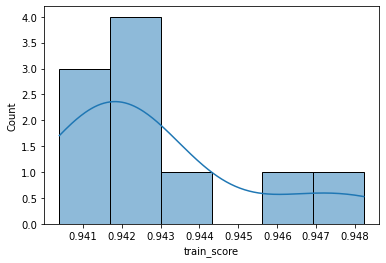


Distribuição de métricas de teste:


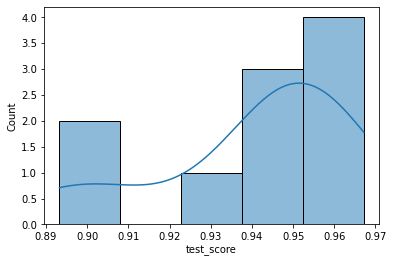


As duas juntas (compare a variância!):


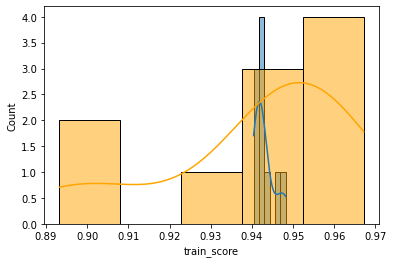

In [61]:
lr = LogisticRegression(penalty="l1", C=1.2, solver="liblinear")

plot_cv(lr, X_clf, y_clf, n_splits=10, scoring="roc_auc")

,train_roc_auc,test_roc_auc
count,10.000000,10.000000
mean,0.942937,0.940544
std,0.002502,0.023745
min,0.940402,0.893268
25%,0.941513,0.935897
50%,0.941980,0.951190
75%,0.943034,0.953301
max,0.948221,0.967159



Distribuição da métrica roc_auc de treino:


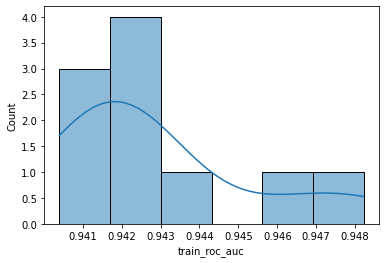


Distribuição da métrica roc_auc de teste:


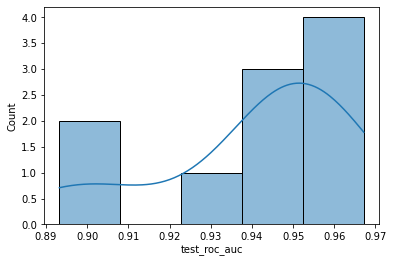


As duas juntas (compare a variância!):


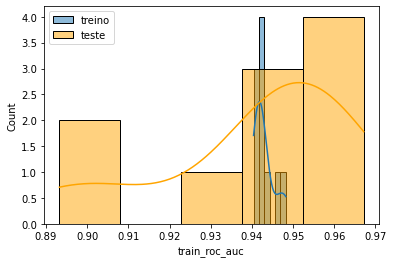

################################################################################


,train_f1,test_f1
count,10.000000,10.000000
mean,0.885043,0.880805
std,0.003964,0.050534
min,0.879650,0.800000
25%,0.881283,0.859838
50%,0.885964,0.874960
75%,0.888141,0.920000
max,0.890323,0.947368



Distribuição da métrica f1 de treino:


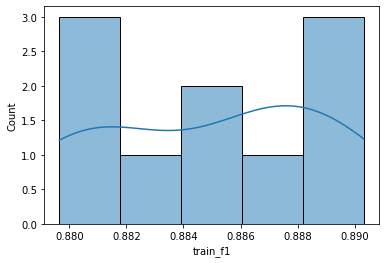


Distribuição da métrica f1 de teste:


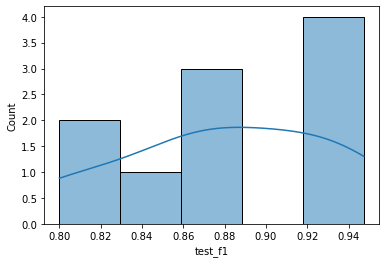


As duas juntas (compare a variância!):


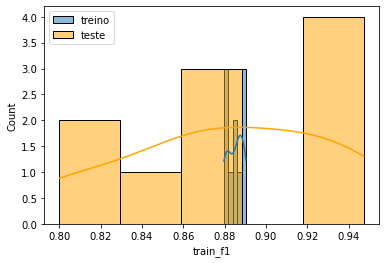

################################################################################


In [62]:
lr = LogisticRegression(penalty="l1", C=1.2, solver="liblinear")

plot_cv_varias_metricas(lr, X_clf, y_clf, n_splits=10, scoring=("roc_auc", "f1"))

____________

## 2) Ajuste de hiperparâmetros

Além de permitir uma avaliação mais robusta de um modelo, o CV pode também ser utilizado para um propósito muito importante: **a escolha de valores adequados de hiperparâmetros** de um modelo -- processo conhecido como **hyperparameter tuning**.

<img src=https://www.okw.com/en/Com-Knobs/COM-KNOBS-class-OKW_GroupInfoImage500x408.jpg width=400>

Na aula que vem vamos estudar uma forma mais estruturada de fazer este procedimento.

Mas, nesta aula, vamos ver formas automáticas e diretas de aplicar CV aos modelos que conhecemos!

Antes de irmos pra prática, uma pergunta importante é: **como/por que utilizar CV para o ajuste de hiperparâmetros?**

Ao testarmos diferentes valores/combinações de hiperparâmetros em diferentes folds, temos uma estimativa mais realista sobre o efeito destas escolhas: se o resultado for bom em todos os folds (ou bom em média), temos um indicativo mais robusto de que de fato aquela é uma boa escolha. Em particular, fica muito mais difícil de cometermos **overfitting** através da escolha de hiperparâmetros que ajustem muito bem uma única base de treino. Faz sentido, né?

Para saber mais sobre estas questões, sugiro [este post](https://towardsdatascience.com/cross-validation-and-hyperparameter-tuning-how-to-optimise-your-machine-learning-model-13f005af9d7d) e [este post](https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/).

No sklearn, temos o procedimento de CV incorporado a algumas classes de hipóteses:

- [Lasso CV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html)
- [Ridge CV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html)
- [ElasticNetCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html)
- [LogisticRegressionCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html)

Em todos os casos, é possível especificar uma lista de hiperparâmetros a serem percorridos, e o modelo com melhor hiperparâmetro (ou combinação de hiperparâmetros) é escolhido! 

Vamos pegar as bases acima e aplicar os métodos de CV built-in pra ver se encontramos resultados melhores:

In [63]:
# criando dados 
np.linspace(0.1, 1, 100)

array([0.1       , 0.10909091, 0.11818182, 0.12727273, 0.13636364,
       0.14545455, 0.15454545, 0.16363636, 0.17272727, 0.18181818,
       0.19090909, 0.2       , 0.20909091, 0.21818182, 0.22727273,
       0.23636364, 0.24545455, 0.25454545, 0.26363636, 0.27272727,
       0.28181818, 0.29090909, 0.3       , 0.30909091, 0.31818182,
       0.32727273, 0.33636364, 0.34545455, 0.35454545, 0.36363636,
       0.37272727, 0.38181818, 0.39090909, 0.4       , 0.40909091,
       0.41818182, 0.42727273, 0.43636364, 0.44545455, 0.45454545,
       0.46363636, 0.47272727, 0.48181818, 0.49090909, 0.5       ,
       0.50909091, 0.51818182, 0.52727273, 0.53636364, 0.54545455,
       0.55454545, 0.56363636, 0.57272727, 0.58181818, 0.59090909,
       0.6       , 0.60909091, 0.61818182, 0.62727273, 0.63636364,
       0.64545455, 0.65454545, 0.66363636, 0.67272727, 0.68181818,
       0.69090909, 0.7       , 0.70909091, 0.71818182, 0.72727273,
       0.73636364, 0.74545455, 0.75454545, 0.76363636, 0.77272

In [64]:
from sklearn.linear_model import LassoCV

kf5 = KFold(n_splits=10, shuffle=True, random_state=42)

l1 = LassoCV(alphas=np.linspace(0.1, 1, 100), cv=kf5, verbose=50).fit(X, y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
(array([-0.        , 81.26206618, -0.        , 66.71317838, 10.99012932]), 0.7174938777461648, 556.4634617202245, 4)
(array([-0.        , 81.27078268, -0.        , 66.7214594 , 10.99968657]), 0.622853877604939, 556.4634617202245, 2)
(array([-0.        , 81.27950165, -0.        , 66.72974008, 11.00924357]), 0.622910920646973, 556.4634617202245, 2)
(array([-0.        , 81.28822062, -0.        , 66.73802076, 11.01880057]), 0.6229856655118056, 556.4634617202245, 2)
(array([-0.        , 81.29693959, -0.        , 66.74630145, 11.02835757]), 0.6230604154407047, 556.4634617202245, 2)
(array([-0.        , 81.30565856, -0.        , 66.75458213, 11.03791457]), 0.6231351672904566, 556.4634617202245, 2)
(array([-0.        , 81.31437753, -0.        , 66.76286281, 11.04747157]), 0.6232099171029404, 556.4634617202245, 2)
(array([-0.        , 81.3230965 , -0.        , 66.77114349, 11.05702856]), 0.6232846679631621, 556.463

(array([-0.        , 81.59315826, -0.        , 67.08073292, 11.74016291]), 0.0592335294932127, 548.2674224191175, 2)
(array([-0.        , 81.60229064, -0.        , 67.08922442, 11.74928472]), 0.05924030649475753, 548.2674224191175, 2)
(array([-0.        , 81.61142301, -0.        , 67.09771593, 11.75840653]), 0.0592470818082802, 548.2674224191175, 2)
(array([-0.        , 81.62055539, -0.        , 67.10620743, 11.76752833]), 0.059253857121802866, 548.2674224191175, 2)
(array([-0.        , 81.62968777, -0.        , 67.11469893, 11.77665014]), 0.059260633774101734, 548.2674224191175, 2)
(array([-0.        , 81.63882014, -0.        , 67.12319044, 11.78577195]), 0.05926740728318691, 548.2674224191175, 2)
(array([-0.        , 81.64795252, -0.        , 67.13168194, 11.79489376]), 0.05927418451756239, 548.2674224191175, 2)
(array([-0.        , 81.6570849 , -0.        , 67.14017344, 11.80401557]), 0.05928095895797014, 548.2674224191175, 2)
(array([-0.        , 81.66621727, -0.        , 67.148664

In [65]:
l1

LassoCV(alphas=array([0.1       , 0.10909091, 0.11818182, 0.12727273, 0.13636364,
       0.14545455, 0.15454545, 0.16363636, 0.17272727, 0.18181818,
       0.19090909, 0.2       , 0.20909091, 0.21818182, 0.22727273,
       0.23636364, 0.24545455, 0.25454545, 0.26363636, 0.27272727,
       0.28181818, 0.29090909, 0.3       , 0.30909091, 0.31818182,
       0.32727273, 0.33636364, 0.34545455, 0.35454545, 0.36363636,
       0.37272727, 0.381818...
       0.73636364, 0.74545455, 0.75454545, 0.76363636, 0.77272727,
       0.78181818, 0.79090909, 0.8       , 0.80909091, 0.81818182,
       0.82727273, 0.83636364, 0.84545455, 0.85454545, 0.86363636,
       0.87272727, 0.88181818, 0.89090909, 0.9       , 0.90909091,
       0.91818182, 0.92727273, 0.93636364, 0.94545455, 0.95454545,
       0.96363636, 0.97272727, 0.98181818, 0.99090909, 1.        ]),
        cv=KFold(n_splits=10, random_state=42, shuffle=True), verbose=50)

In [66]:
l1.alpha_

0.4545454545454546

In [69]:
from sklearn.linear_model import ElasticNetCV

kf5 = KFold(n_splits=10, shuffle=True, random_state=42)

en = ElasticNetCV(alphas=np.linspace(0.5, 1, 20), l1_ratio=np.linspace(0.1, 1, 20),
                  cv=kf5, verbose=50).fit(X, y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
(array([-6.28259509e-01,  4.22041148e+01, -2.99203665e-03,  3.74746584e+01,
        7.57988362e+00]), 0.07002397230826318, 556.4634617202245, 4)
(array([-6.31421067e-01,  4.27510683e+01, -5.20206623e-03,  3.79205084e+01,
        7.66065253e+00]), 0.06395944464020431, 556.4634617202245, 3)
(array([-6.34520871e-01,  4.33123848e+01, -7.45702811e-03,  3.83770478e+01,
        7.74300924e+00]), 0.07679845718666911, 556.4634617202245, 3)
(array([-6.37551092e-01,  4.38886392e+01, -9.75708792e-03,  3.88446649e+01,
        7.82699423e+00]), 0.09087577764876187, 556.4634617202245, 3)
(array([-6.40503605e-01,  4.44804375e+01, -1.21021068e-02,  3.93237672e+01,
        7.91264880e+00]), 0.10412634839303792, 556.4634617202245, 3)
(array([-6.43369496e-01,  4.50884192e+01, -1.44917648e-02,  3.98147821e+01,
        8.00001505e+00]), 0.11239876644685864, 556.4634617202245, 3)
(array([-6.46139746e-01,  4.57132594e+01, -1.6925

(array([-0.6246829 , 54.38960796, -0.        , 46.560936  ,  9.49314848]), 0.0004553012549877167, 548.2674224191175, 3)
(array([-0.62474115, 55.20928574, -0.        , 47.20851702,  9.60436898]), 0.0005161343142390251, 548.2674224191175, 3)
(array([-0.62443359, 56.05398935, -0.        , 47.87426796,  9.71789649]), 0.0005855122581124306, 548.2674224191175, 3)
(array([-0.62372738, 56.92488529, -0.        , 48.55896435,  9.8337868 ]), 0.0006647414993494749, 548.2674224191175, 3)
(array([-0.6225867 , 57.82321385, -0.        , 49.26342644,  9.9520959 ]), 0.000755341025069356, 548.2674224191175, 3)
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:    0.1s remaining:    0.0s
(array([-0.49722351, 43.13134696, -0.45352652, 37.93390866,  8.03406611]), 0.003682213369756937, 521.1700008574629, 4)
(array([-0.49817387, 43.67990564, -0.45214091, 38.38188302,  8.1134941 ]), 0.027533898130059242, 521.1700008574629, 3)
(array([-0.49894728, 44.24254001, -0.45043961, 38.8405108 ,  8.19431499]), 0.029689

(array([-0.58920258, 48.24200284,  0.23944766, 42.31733203,  8.72539788]), 0.022557398304343224, 541.804515651971, 3)
(array([-0.59171602, 48.79102212,  0.24104429, 42.75534475,  8.80583098]), 0.02419989136978984, 541.804515651971, 3)
(array([-0.59409864, 49.35255883,  0.24255991, 43.20242751,  8.88756521]), 0.025976780685596168, 541.804515651971, 3)
(array([-0.59634061, 49.92704641,  0.24398885, 43.65886558,  8.97062726]), 0.02790044667199254, 541.804515651971, 3)
(array([-0.5984314 , 50.51493855,  0.24532511, 44.12495635,  9.05504422]), 0.029984547290951014, 541.804515651971, 3)
(array([-0.6003598 , 51.1167104 ,  0.2465623 , 44.60100997,  9.14084356]), 0.03224416368175298, 541.804515651971, 3)
(array([-0.60211385, 51.73285988,  0.24769365, 45.08735008,  9.22805307]), 0.03469596151262522, 541.804515651971, 3)
(array([-0.60368074, 52.36390902,  0.24871197, 45.5843145 ,  9.31670083]), 0.037358385627157986, 541.804515651971, 3)
(array([-0.60504683, 53.01040547,  0.24960962, 46.09225605, 

(array([-0.        , 55.90656523,  0.4200315 , 48.01053194,  9.223743  ]), 0.016950948163866997, 572.5946116755196, 3)
(array([-0.        , 56.49594894,  0.42091019, 48.47995844,  9.30302208]), 0.018045249045826495, 572.5946116755196, 3)
(array([-0.        , 57.09774261,  0.4216092 , 48.95851833,  9.38343201]), 0.01921970199327916, 572.5946116755196, 3)
(array([-0.        , 57.71234307,  0.42211777, 49.44648109,  9.46499097]), 0.02048092079348862, 572.5946116755196, 3)
(array([-0.        , 58.34016427,  0.42242453, 49.94412691,  9.54771711]), 0.02183613320812583, 572.5946116755196, 3)
(array([-0.        , 58.98163825,  0.42251746, 50.45174721,  9.63162851]), 0.023293234640732408, 572.5946116755196, 3)
(array([-0.        , 59.63721611,  0.42238383, 50.96964528,  9.71674313]), 0.024860869394615293, 572.5946116755196, 3)
(array([ 0.        , 60.30736909,  0.42201014, 51.49813681,  9.80307871]), 0.026548491441644728, 572.5946116755196, 3)
(array([ 0.        , 60.99258969,  0.42138213, 52.0

(array([-0.32135455, 60.53359498, -0.        , 51.34128549, 10.0574106 ]), 0.0005874981870874763, 548.2674224191175, 3)
(array([-0.3268956 , 61.07963757, -0.        , 51.76606182, 10.13231216]), 0.0006314502097666264, 548.2674224191175, 3)
(array([-0.33238614, 61.63542877, -0.        , 52.19774168, 10.20808349]), 0.0006788828177377582, 548.2674224191175, 3)
(array([-0.33782114, 62.20123271, -0.        , 52.63649473, 10.28473532]), 0.0007300983415916562, 548.2674224191175, 3)
(array([-0.34319528, 62.77732317, -0.        , 53.08249618, 10.36227829]), 0.0007854185532778502, 548.2674224191175, 3)
(array([-0.34850289, 63.36398404, -0.        , 53.53592711, 10.44072297]), 0.0008452074253000319, 548.2674224191175, 3)
(array([-0.35373801, 63.96150976, -0.        , 53.99697468, 10.52007975]), 0.0009098529117181897, 548.2674224191175, 3)
(array([-0.35889426, 64.57020587, -0.        , 54.46583237, 10.60035889]), 0.0009797877864912152, 548.2674224191175, 3)
(array([-0.36396492, 65.19038949, -0.   

(array([-0.07108555, 62.90437965, -0.        , 53.14661019, 10.15325075]), 0.0012179380282759666, 548.2674224191175, 4)
(array([-0.08017738, 63.30447511, -0.        , 53.456436  , 10.21122417]), 0.0005689935060217977, 548.2674224191175, 3)
(array([-0.08930624, 63.70950838, -0.        , 53.76972891, 10.26966827]), 0.0005985952448099852, 548.2674224191175, 3)
(array([-0.09847145, 64.11957168, -0.        , 54.08654743, 10.32858721]), 0.0006298195803537965, 548.2674224191175, 3)
(array([-0.1076724 , 64.53475958, -0.        , 54.40695138, 10.38798517]), 0.0006627627881243825, 548.2674224191175, 3)
(array([-0.11690844, 64.95516904, -0.        , 54.73100196, 10.44786627]), 0.0006975251017138362, 548.2674224191175, 3)
(array([-0.12617886, 65.38089946, -0.        , 55.05876174, 10.50823464]), 0.0007342186290770769, 548.2674224191175, 3)
(array([-0.13548293, 65.81205283, -0.        , 55.39029476, 10.56909438]), 0.000772954779677093, 548.2674224191175, 3)
(array([-0.14481983, 66.24873374, -0.    

(array([-1.11187594e-02,  7.37680017e+01, -0.00000000e+00,  6.15512350e+01,
        1.08321785e+01]), 0.046916507417336106, 556.4634617202245, 3)
(array([-2.91628344e-02,  7.40523073e+01, -0.00000000e+00,  6.17574508e+01,
        1.08749065e+01]), 0.04796059668296948, 556.4634617202245, 3)
(array([-4.73215432e-02,  7.43386629e+01, -0.00000000e+00,  6.19649206e+01,
        1.09178012e+01]), 0.04905655444599688, 556.4634617202245, 3)
(array([-6.55960741e-02,  7.46270909e+01, -0.00000000e+00,  6.21736558e+01,
        1.09608628e+01]), 0.05018081224989146, 556.4634617202245, 3)
(array([-0.08398764, 74.91761414, -0.        , 62.38366785, 11.00409141]), 0.05133418116020039, 556.4634617202245, 3)
(array([-0.10249746, 75.21025571, -0.        , 62.59496847, 11.04748712]), 0.052517501753754914, 556.4634617202245, 3)
(array([-0.12112678, 75.50503909, -0.        , 62.8075694 , 11.09104994]), 0.053731645457446575, 556.4634617202245, 3)
(array([-0.13987688, 75.80198809, -0.        , 63.02148258, 11.

(array([-0.        , 77.27543731, -0.        , 64.56936835, 11.22164555]), 0.03905211738310754, 549.3879082205762, 2)
(array([-0.        , 77.39612552, -0.        , 64.66295467, 11.25936431]), 0.03928985761012882, 549.3879082205762, 2)
(array([-0.        , 77.51711327, -0.        , 64.75674806, 11.29717393]), 0.039529301924631, 549.3879082205762, 2)
(array([-0.        , 77.63840167, -0.        , 64.85074921, 11.33507475]), 0.03977050201501697, 549.3879082205762, 2)
(array([-0.        , 77.75999186, -0.        , 64.9449588 , 11.37306709]), 0.040013468940742314, 549.3879082205762, 2)
(array([-0.        , 77.88188494, -0.        , 65.03937753, 11.41115128]), 0.040258222608827055, 549.3879082205762, 2)
(array([-0.        , 78.00408207, -0.        , 65.13400609, 11.44932766]), 0.040504776348825544, 549.3879082205762, 2)
(array([-0.        , 78.12658437, -0.        , 65.22884519, 11.48759656]), 0.04075314418878406, 549.3879082205762, 2)
(array([-4.89001939e-03,  7.82494484e+01, -0.00000000e+

In [70]:
en.alpha_

0.5

In [71]:
en.l1_ratio_

1.0

### Agora é sua vez!!

- 1 - Teste diferentes regressores CV com a base house_prices
    - Aumente a complexidade da hipótese permitindo uma regressão polinomial, e deixe o CV decidir uma boa regularização!
    

In [ ]:
# house_prices


- 2 - Aplique o logit com CV à base breast_cancer

In [ ]:
# breast_cancer
